# * Collapse gtex tissue annotation

In [21]:
source('src/pdtime.r')
t0 = Sys.time()
library(data.table)
gtex = fread('data/gtex_5e-08_745.tsv')
print(dim(dat)); head(dat)
cat(paste0('\n',pdtime(t0,1),'\n'))

[1] 29785     9


variant_id,gene_id,pval_nominal,slope,slope_se,tissue,chr,variant_pos,rsid
1_114426001_G_A_b37,ENSG00000226167.1,2.58854e-10,-0.498565,0.0756303,Cells_Transformed_fibroblasts,1,114426001,rs11102694
1_114429461_G_A_b37,ENSG00000226167.1,8.37389e-11,-0.510813,0.0752620,Cells_Transformed_fibroblasts,1,114429461,rs2358994
1_114429515_A_C_b37,ENSG00000226167.1,7.56856e-11,-0.513570,0.0754759,Cells_Transformed_fibroblasts,1,114429515,rs2358995
1_114431463_G_A_b37,ENSG00000226167.1,3.54926e-10,-0.495715,0.0758333,Cells_Transformed_fibroblasts,1,114431463,rs7547478
1_114445880_G_A_b37,ENSG00000226167.1,5.32221e-11,-0.513291,0.0747756,Cells_Transformed_fibroblasts,1,114445880,rs7513707
1_114448389_C_T_b37,ENSG00000226167.1,2.40206e-11,-0.526891,0.0752834,Cells_Transformed_fibroblasts,1,114448389,rs11552449



Job done: 2019-01-16 16:59:32 for 0 sec


In [29]:
library(dplyr)
gtex_ = gtex[,c(9,6)]; head(gtex_,3)
gtex_col = gtex_ %>%
    group_by(rsid) %>%
    summarise_each(funs(paste(.,collapse='; ')))
head(gtex_col,3)

rsid,tissue
rs11102694,Cells_Transformed_fibroblasts
rs2358994,Cells_Transformed_fibroblasts
rs2358995,Cells_Transformed_fibroblasts


`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


rsid,tissue
rs1004446,Liver
rs1008723,Artery_Tibial; Esophagus_Muscularis; Esophagus_Gastroesophageal_Junction; Spleen; Small_Intestine_Terminal_Ileum; Adipose_Visceral_Omentum; Cells_EBV-transformed_lymphocytes; Whole_Blood; Esophagus_Mucosa; Testis; Muscle_Skeletal; Pancreas; Whole_Blood; Colon_Transverse; Spleen; Stomach; Thyroid; Adipose_Subcutaneous; Nerve_Tibial; Heart_Left_Ventricle; Lung; Cells_EBV-transformed_lymphocytes; Lung; Stomach
rs1013971,Adipose_Visceral_Omentum; Skin_Sun_Exposed_Lower_leg; Lung; Esophagus_Mucosa; Thyroid; Esophagus_Muscularis; Cells_Transformed_fibroblasts; Artery_Aorta; Stomach; Nerve_Tibial; Artery_Coronary; Esophagus_Gastroesophageal_Junction; Artery_Tibial; Adipose_Subcutaneous; Colon_Sigmoid; Adrenal_Gland; Esophagus_Mucosa; Skin_Not_Sun_Exposed_Suprapubic


rs1008723에 Whole_Blood가 두 개 있다?!

# Generate random SNP sets

In [51]:
suppressMessages(library(plyr))
suppressMessages(library(data.table))
source('src/pdtime.r')
source('src/saveasrds.r')
t0 = Sys.time()

dir = 'db/dbSNP/'
dir2 = 'random/'
chr = c(1:22,'X','Y','MT')

cat('\n(2/3) Reading dbSNP data RDS files..\n')
f_name2 = paste0(dir,'bed_chr_',chr,'.bed.rds')
n=length(f_name2)
snp.li = lapply(c(21:22,24:25),function(i) {
    f = f_name2[i]
    if(file.exists(f)) {
        tb = try(as.data.frame(readRDS(f)))
        if('try-error' %in% class(tb)) stop('There is no dbSNP RDS files before this process.') # check no file error
        cat(paste0('\t(',i,'/',n,') ',
               basename(f),', rows= ',dim(tb)[1],' cols= ',dim(tb)[2],', ',
               pdtime(t0,2),'\n'))
        return(tb)
    } else cat(paste0('None such file: ',f))
})
snp.df = ldply(snp.li,data.frame)[,c(1:3,6)] # plyr
cat(paste0('\n >> SNP table, rows= ',dim(snp.df)[1],' cols= ',dim(snp.df)[2],'\n'))
cat(paste0(' >> ',pdtime(t0,2),'\n'))


(2/3) Reading dbSNP data RDS files..
	(21/25) bed_chr_21.bed.rds, rows= 8348293 cols= 7, Job process: 7.8 sec
	(22/25) bed_chr_22.bed.rds, rows= 8374360 cols= 7, Job process: 11.7 sec
	(24/25) bed_chr_Y.bed.rds, rows= 468465 cols= 7, Job process: 11.9 sec
	(25/25) bed_chr_MT.bed.rds, rows= 2296 cols= 7, Job process: 11.9 sec

 >> SNP table, rows= 17193414 cols= 4
 >> Job process: 20 sec


In [125]:
cat('\n(3/3) Generating random-sets of SNPs\n')
n_snp = 1817
n_snp_set = 1
cat(paste0('  - SNP_number = ',n_snp,'\n  - SNP_set_number = ',n_snp_set,'\n'))
t=lapply(c(1:n_snp_set),function(i) {
	rd.row = sample(nrow(snp.df),n_snp)
	rd.df  = snp.df[rd.row,]
    #rd.df  = rd.df[sort(rownames(rd.df)),]
    m=nrow(rd.df)
    rd.li=lapply(c(1:m),function(j) {
        row   = t(unname(rd.df[j,]))
        row_2 = as.numeric(row[2])
        row_3 = as.numeric(row[3])
        if(row_3-row_2<0) {
            row_ = c(row[c(1,3,2,4)],row_3-row_2)
        } else {
            row_ = c(row,row_3-row_2)
        }
        return(t(row_))
    })
    rd.df_ = ldply(rd.li,data.frame)
    f_name = paste0(dir2,'rsid',i,'.bed')
	write.table(rd.df_,f_name,row.names=F,col.names=F,quote=F,sep='\t')
    cat(paste0('>> File write: ',f_name,'\n'))
})


(3/3) Generating random-sets of SNPs
  - SNP_number = 1817
  - SNP_set_number = 1
>> File write: random/rsid1.bed


# Random SNP iteration

## 1. Prepare random SNP files

In [3]:
suppressMessages(library(plyr))
suppressMessages(library(data.table))
source('src/pdtime.r')
source('src/saveasrds.r')
t0   = Sys.time()
dir  = 'db/dbSNP/'
dir2 = 'random/'
chr  = c(1:22,'X','Y','MT')

cat('\n(2/3) Reading dbSNP data RDS files..\n')
f_name2 = paste0(dir,'bed_chr_',chr,'.bed.rds')
n=length(f_name2)
snp.li = lapply(c(20:22,24:25),function(i) {
    f = f_name2[i]
    if(file.exists(f)) {
        tb = try(as.data.frame(readRDS(f)))
        if('try-error' %in% class(tb)) stop('There is no dbSNP RDS files before this process.') # check no file error
        cat(paste0('\t(',i,'/',n,') ',
               basename(f),', rows= ',dim(tb)[1],' cols= ',dim(tb)[2],', ',
               pdtime(t0,2),'\n'))
        return(tb)
    } else cat(paste0('None such file: ',f))
})
snp.df = ldply(snp.li,data.frame)[,c(1:3,6)] # plyr
cat(paste0('\n >> SNP table, rows= ',dim(snp.df)[1],' cols= ',dim(snp.df)[2],'\n'))
cat(paste0(' >> ',pdtime(t0,2),'\n'))

Warning message:
"package 'data.table' was built under R version 3.5.2"


(2/3) Reading dbSNP data RDS files..
	(20/25) bed_chr_20.bed.rds, rows= 13664413 cols= 7, Job process: 16.4 sec
	(21/25) bed_chr_21.bed.rds, rows= 8348293 cols= 7, Job process: 34.7 sec
	(22/25) bed_chr_22.bed.rds, rows= 8374360 cols= 7, Job process: 49.1 sec
	(24/25) bed_chr_Y.bed.rds, rows= 468465 cols= 7, Job process: 49.5 sec
	(25/25) bed_chr_MT.bed.rds, rows= 2296 cols= 7, Job process: 49.5 sec

 >> SNP table, rows= 30857827 cols= 4
 >> Job process: 1.3 min


In [5]:
t0   = Sys.time()
n_snp_set = 10
n_snp = 1817
t=lapply(c(1:n_snp_set),function(i) {
    rd.row = sample(nrow(snp.df),n_snp)
    rd.df  = snp.df[rd.row,]
    f_name = paste0(dir2,'rsid',i,'.bed')
    write.table(rd.df,f_name,row.names=F,col.names=F,quote=F,sep='\t')
    #cat(paste0(' >> File write: ',f_name,'\n'))
})
cat(paste0('\n >> ',pdtime(t0,1),'\n'))


 >> Job done: 2019-01-18 20:59:01 for 0.2 sec


### Fixing the start > end problem

- Run following `SHELL` script:

`$ awk -F\t '$2>$3{print $1,$3,$2,$4; next}{print $0}' random/rsid1.bed > random/rsid1_.bed`

```SHELL
for i in $(seq 1 10); do
    path='random/rsid'$i'.bed'
    name=${path%%.*}'_.bed'
    awk -F\t '$2>$3{print $1,$3,$2,$4; next}{print $0}' $path > $name
done
```

## 2. Prepare roadmap command lines
  - CMD: `dir > list.tsv`
  - In excel, generate iterative `SHELL` command lines
    - `bedtools closest -d -a random/rsid1.bed -b db/roadmap_enh_merge.bed > random/data/roadmap_rsid1.tsv`
    - `bedtools closest -d -a random/rsid2.bed -b db/roadmap_enh_merge.bed > random/data/roadmap_rsid2.tsv`
    - ...
  - Save the command lines as `roadmap_random.sh` and run.

## 3. Run Roadmap analysis

- see `src/bedtools_cloest_random.r` file for the complete version.

In [139]:
rsid = c(1:10)
path = paste0(dir,'roadmap_rsid',rsid,'.tsv')
rd.li = list(); n = length(path)
rd.li = lapply(c(1:n),function(i) {
    # 1. Compiling SNP data distant from RoadMap enhancers
    rd = as.data.frame(fread(path[i])) # data.table
    cat(paste0(' (',i,'/',n,') ',path[i],'\n'))
    pos  = unlist(apply(rd,1,function(x) paste0(x[6],':',x[7],'-',x[8])))
    rd_  = cbind(rd[1:4],pos,rd[,9:10])
    colnames(rd_) = c('chr','start','end','rsid','enh_pos','num','dist')
    dis = as.numeric(as.character(rd_$dist))
    rd.df = cbind(rd_[1:6],dis); head(rd.df)
    
    # 2. Filtering SNPs by distance of closest enhancers
    rd.df_ = unique(subset(rd.df,dis==0))
    rd.df_snp = length(unique(rd.df_$rsid))
    rd.df_enh = length(unique(rd.df_$enh_pos))
    
    rd.row = c(basename(path[i]),rd.df_snp,rd.df_enh)
    return(t(rd.row))
})
rd.df_ = ldply(rd.li,data.frame) # plyr
colnames(rd.df_) = c('random','SNP_n','Enh_n')
                  
f.path = paste0(dir,'random_dist.tsv')
write.table(rd.df_,f.path,row.names=F,quote=F,sep='\t')
cat(paste0('\nFile write: ',f.path,'\n'))
cat(paste0('\n>> ',pdtime(t0,1),'\n'))

 (1/10)random/roadmap/roadmap_rsid1.tsv
 (2/10)random/roadmap/roadmap_rsid2.tsv
 (3/10)random/roadmap/roadmap_rsid3.tsv
 (4/10)random/roadmap/roadmap_rsid4.tsv
 (5/10)random/roadmap/roadmap_rsid5.tsv
 (6/10)random/roadmap/roadmap_rsid6.tsv
 (7/10)random/roadmap/roadmap_rsid7.tsv
 (8/10)random/roadmap/roadmap_rsid8.tsv
 (9/10)random/roadmap/roadmap_rsid9.tsv
 (10/10)random/roadmap/roadmap_rsid10.tsv

File write: random/roadmap/random_dist.tsv

>> Job done: 2019-01-18 18:33:55 for 20 min


## 4. GTEx analysis

- see complete code in `gtex_random.r`

In [333]:
suppressMessages(library(plyr))
source('src/pdtime.r')
t0 = Sys.time()
# 1. Loading GTEx significant file
cat("\n(1/2) Loading GTEx significant file\n")
gtex = readRDS('db/gtex_signif_5e-8.tsv.rds')
cat(paste0(' - GTEx table, rows= ',dim(gtex)[1],' cols= ',dim(gtex)[2],'\n'))
pdtime(t0,1)

 - GTEx table, rows= 17113536 cols= 9


[1] "Job done: 2019-01-30 11:51:13 for 24.4 sec"

In [334]:
head(gtex)

variant_id,gene_id,pval_nominal,slope,slope_se,tissue,chr,variant_pos,rs_id_dbSNP147_GRCh37p13
1_100000012_G_T_b37,ENSG00000099260.6,6.99181e-10,0.532305,0.0817603,Pancreas,1,100000012,rs10875231
1_100004463_TA_T_b37,ENSG00000099260.6,7.03678e-10,0.525742,0.0807670,Pancreas,1,100004463,rs869166030
1_100004726_G_A_b37,ENSG00000099260.6,2.81063e-18,0.923973,0.0950254,Pancreas,1,100004726,rs6682190
1_100005477_G_A_b37,ENSG00000099260.6,1.75862e-17,0.897595,0.0950940,Pancreas,1,100005477,rs12069019
1_100006734_C_T_b37,ENSG00000099260.6,2.90141e-14,0.835423,0.1011750,Pancreas,1,100006734,rs55725529
1_100007454_C_T_b37,ENSG00000099260.6,1.75862e-17,0.897595,0.0950940,Pancreas,1,100007454,rs12082355


In [346]:
# 2. eQTL SNP filter iteration
t0 = Sys.time()
cat("\n(2/2) eQTL SNP filter iteration\n")
dir_out = 'random/gtex'
f_name = 'random/gtex_dist.tsv'
dir.create(file.path(dir_out))

rsid = c(1:10)
rd_name = paste0('gtex_rsid',rsid,'.bed')
rd_path = paste0('random/seeds/rsid',rsid,'.bed')
colnames(gtex)[9] = 'rsid'
rd.li = list(); n = length(rd_path)
rd.li = lapply(c(1:n),function(i) {
    rd = as.data.frame(fread(rd_path[i])) # data.table
    colnames(rd) = c('chr','start','end','rsid')
    cat(paste0('\t(',i,'/',n,') ',rd_path[i],'\n'))
    gtex_ = subset(gtex,rsid%in%rd$rsid)
    write.table(gtex_,paste0(dir_out,'/gtex_rsid',rsid[i],'.tsv'),
                row.names=F,quote=F,sep='\t')
    
    eqtl_snp_n  = length(unique(gtex_$rsid))
    asso_gene_n = length(unique(gtex_$gene_id))
    rd.row = c(rd_name[i],eqtl_snp_n,asso_gene_n)
    return(t(rd.row))
})
rd_df = ldply(rd.li,data.frame) # plyr
colnames(rd_df) = c('random','SNP_n','Gene_n')
write.table(rd_df,f_name,row.names=F,quote=F,sep='\t')
cat(paste0('\nFile write: ',f_name,'\n'))
cat(paste0('>> ',pdtime(t0,1),'\n'))


(2/2) eQTL SNP filter iteration


Warning message in dir.create(file.path(dir_out)):
"'random\gtex' already exists"

	(1/10) random/seeds/rsid1.bed
	(2/10) random/seeds/rsid2.bed
	(3/10) random/seeds/rsid3.bed
	(4/10) random/seeds/rsid4.bed
	(5/10) random/seeds/rsid5.bed
	(6/10) random/seeds/rsid6.bed
	(7/10) random/seeds/rsid7.bed
	(8/10) random/seeds/rsid8.bed
	(9/10) random/seeds/rsid9.bed
	(10/10) random/seeds/rsid10.bed

File write: random/gtex_dist.tsv
>> Job done: 2019-01-30 12:25:53 for 6.4 sec


## 5. lncRNASNP2

- See the complete code at `lncrnasnp_random.r` file.

In [363]:
suppressMessages(library(plyr))
suppressMessages(library(data.table))
source('src/pdtime.r')
t0 = Sys.time()

# 1. Read DB files..
cat("\n(1/2) Read DB files..\n")
snplnc_path = 'db/lncRNASNP2_snplist.txt.rds'
ann_path = 'db/lncrnas.txt.rds'
dis_path = 'db/lncrna-diseases_experiment.txt.rds'

snplnc = readRDS(snplnc_path)
cat(paste0('  - ',snplnc_path,'; ',pdtime(t0,2),'\n'))

ann = readRDS(ann_path)
colnames(ann)[1] = 'lncRNA'
cat(paste0('  - ',ann_path,'; ',pdtime(t0,2),'\n'))

dis = readRDS(dis_path)
cat(paste0('  - ',dis_path,'; ',pdtime(t0,2),'\n'))

  - db/lncRNASNP2_snplist.txt.rds; Job process: 7.6 sec
  - db/lncrnas.txt.rds; Job process: 7.7 sec
  - db/lncrna-diseases_experiment.txt.rds; Job process: 7.7 sec


In [376]:
t0 = Sys.time()
dir_out = 'random/lncrna'
dir.create(file.path(dir_out))
f_name = 'random/lncrna_dist.tsv'

# 2. Random SNP iteration
rsid = c(1:10)
rd_name = paste0('lncrna_rsid',rsid,'.bed')
rd_path = paste0('random/seeds/rsid',rsid,'.bed')

cat("\n(2/2) Random SNP iteration\n")
n=length(rd_path)
rd_li=lapply(c(1:n),function(i) {
    # Read SNPs
    snp_df = read.delim(rd_path[i],header=F)
    colnames(snp_df) = c('chr','start','end','dbsnp')
    cat(paste0('\t(',i,'/',n,') ',rd_path[i],'\n'))
    
    # Merge and annotate SNPs within lncRNAs
    snp_lnc = merge(snp_df,snplnc,by='dbsnp')
    snp_lnc_ann = merge(snp_lnc[,c(1,5)],ann,by='lncRNA',all.x=T)
    snp_lnc_ann_dis = merge(snp_lnc_ann,dis,by='lncRNA',all.x=T)
    f_name1 = paste0(dir_out,'/',rd_name[i])
    write.table(snp_lnc_ann_dis,f_name1,row.names=F,quote=F,sep='\t')
    
    # Count numbers for return
    df_n = data.frame(random  =rd_name[i],
                      SNP_n   =c(length(unique(snp_lnc$dbsnp))),
                      lncRNA_n=c(length(unique(snp_lnc$lncRNA))))
    return(df_n)
})
rd_df = ldply(rd_li,data.frame) # plyr
colnames(rd_df) = c('random','SNP_n','lncRNA_n')
write.table(rd_df,f_name,row.names=F,quote=F,sep='\t')
cat(paste0('\nFile write: ',f_name,'\n'))
cat(paste0(pdtime(t0,1),'\n'))

Warning message in dir.create(file.path(dir_out)):
"'random\lncrna' already exists"


(2/2) Random SNP iteration
	(1/10) random/seeds/rsid1.bed
	(2/10) random/seeds/rsid2.bed
	(3/10) random/seeds/rsid3.bed
	(4/10) random/seeds/rsid4.bed
	(5/10) random/seeds/rsid5.bed
	(6/10) random/seeds/rsid6.bed
	(7/10) random/seeds/rsid7.bed
	(8/10) random/seeds/rsid8.bed
	(9/10) random/seeds/rsid9.bed
	(10/10) random/seeds/rsid10.bed

File write: random/lncrna_dist.tsv

Job done: 2019-01-31 12:09:52 for 19.8 sec


## #. Monte Carlo simulation results

- Summarizing the results as table
- Calculate p-value using `t.test` function.

In [44]:
# 1. Read distribution files
suppressMessages(library(dplyr))
roadmap  = read.delim('random/roadmap_dist.tsv'); roadmap %>% dim %>% paste0('  ') %>% cat
encode   = read.delim('random/encode_dist.tsv'); encode %>% dim %>% paste0('  ') %>% cat
regulome = read.delim('random/regulome_dist.tsv'); regulome %>% dim %>% paste0('  ') %>% cat
overlap1 = read.delim('random/overlap1_dist.tsv'); overlap1 %>% dim %>% paste0('  ') %>% cat
overlap2 = read.delim('random/overlap2_dist.tsv'); overlap2 %>% dim %>% paste0('  ') %>% cat
gtex     = read.delim('random/gtex_dist.tsv'); gtex %>% dim %>% paste0('  ') %>% cat
lncrna   = read.delim('random/lncrna_dist.tsv'); lncrna %>% dim %>% paste0('  ') %>% cat

10000   3  10000   3  10000   3  10000   3  10000   3  10000   3  10000   3  

In [ ]:
colnames(lncrna)

### RoadMap/ENCODE/RegulomeDB

In [13]:
suppressMessages(library(data.table))
mu.df = c(
    `No. RoadMap SNP`         =484,
    `No. RoadMap Enh`         =188,
    `No. ENCODE SNP`          =364,
    `No. ENCODE TFBS`         =232,
    `No. Regulome 2b`         =94,
    `No. Regulome func motifs`=45,
    `No. Enhancer TFBS SNP`   =140, # overlap1
    `No. Enhancer TFBS`       =85,  # overlap1
    `No. High-prob SNP`       =26,  # overlap2
    `No. GTEx SNP`            =745,
    `No. GTEx Gene`           =159,
    `No. lncRNASNP2 SNP`      =78,
    `No. lncRNASNP2 lncRNA`   =42
)
dist = list(roadmap$SNP_n, roadmap$Enh_n,
            encode$SNP_n,  encode$Enh_n,
            regulome$regulome_2b_n,regulome$func_Motifs,
            overlap1$SNP_n,overlap1$Enh_n,
            overlap2$SNP_n,
            gtex$SNP_n,    gtex$Gene_n,
            lncrna$SNP_n,  lncrna$lncRNA_n)
dist %>% length %>% print

[1] 13


In [32]:
# test one by one
i = 12
z = (mean(dist[[i]])-mu.df[i])/(var(dist[[i]])/sqrt(length(dist[[i]])))
pnorm(abs(z),lower.tail=F)*2
#t.test(dist[[i]],mu=mu.df[i])

No. lncRNASNP2 SNP 
                 0

In [20]:
source('src/getpval.r')
n = length(dist)
df.li = lapply(c(1:n),function(i) {
    p1 = getpval(dist[[i]],mu.df[i],'t.test')
    p2 = getpval(dist[[i]],mu.df[i],'z.test')
    p3 = getpval(dist[[i]],mu.df[i],'approxfun')
    p4 = getpval(dist[[i]],mu.df[i],'rank')
    range = paste0(min(dist[[i]]),'-',max(dist[[i]]))
    df_ = data.frame(T1D=mu.df[i],
                     Range=range,
                     Mean=mean(dist[[i]]),
                     StDev=sd(dist[[i]]),
                     `T-test_p`=p1,
                     `Z-test_p`=p2,
                     `Empirical_p`=p3,
                     `Rank_p`=p4)
    return(df_)
})
df = rbindlist(df.li) # data.table
df_1 = data.frame(`No.`=names(mu.df),df)
write.table(df_1,'random/summary_table.tsv',sep='\t',row.names=F,quote=F)
df_1

No.,T1D,Range,Mean,StDev,T.test_p,Z.test_p,Empirical_p,Rank_p
No. RoadMap SNP,484,369-508,436.6074,18.2551305,0,6.754288e-46,0.004274647,0.00449955
No. RoadMap Enh,188,369-508,436.0069,18.2155382,0,0.000000e+00,0.000000000,0.00009999
No. ENCODE SNP,364,190-302,249.7021,14.7811300,0,0.000000e+00,0.000000000,0.00009999
No. ENCODE TFBS,232,190-302,249.6092,14.7773987,0,7.391495e-16,0.116585436,0.12188781
No. Regulome 2b,94,0-7,1.0487,1.0233440,0,0.000000e+00,0.000000000,0.00009999
No. Regulome func motifs,45,0-7,0.9546,0.9787924,0,0.000000e+00,0.000000000,0.00009999
No. Enhancer TFBS SNP,140,46-107,75.1915,8.5091520,0,0.000000e+00,0.000000000,0.00009999
No. Enhancer TFBS,85,46-107,75.1674,8.5075270,0,4.910994e-42,0.126906994,0.11598840
No. High-prob SNP,26,0-0,0.0000,0.0000000,0,0.000000e+00,0.000000000,0.00009999
No. GTEx SNP,745,0-15,4.6630,2.1545058,0,0.000000e+00,0.000000000,0.00009999


In [384]:
source('src/getpval.r')
n = length(dist); print(n)
for(i in 1:n) {
    getpval(dist[[i]],mu.df[i],'approxfun')
    title = paste0('Monte Carlo permutation (n=10,000)\nfor ',
                   names(mu.df)[i],' = ',mu.df[i])
    p=getdistplot(dist[[i]],mu.df[i])
    f_name = paste0('random/',names(mu.df)[i],'.png')
    ggsave(f_name,plot=p,device='png',width=5,height=5,units='in')
}

[1] 13


### Example:

[1] 0.0676093

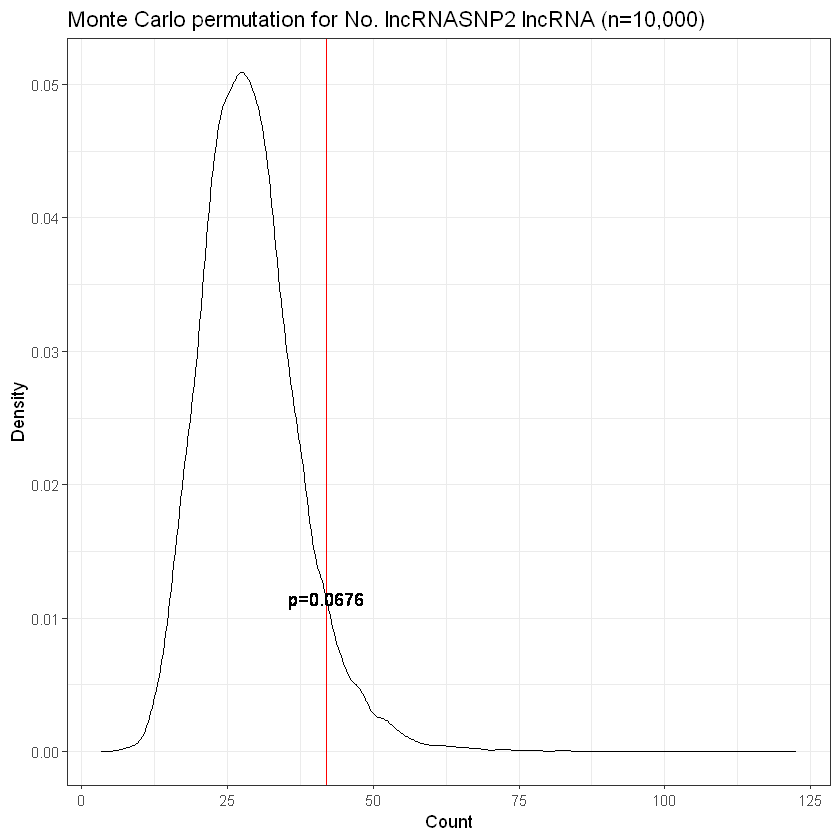

In [387]:
source('src/getpval.r')
i=13
getpval(dist[[i]],mu.df[i],'approxfun')
title = paste0('Monte Carlo permutation for ',
               names(mu.df)[i],' (n=10,000)')
getdistplot(dist[[i]],mu.df[i],title)